<a href="https://colab.research.google.com/github/bum3632/pdm13/blob/main/py-tensorflow/pdm13_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **final** **exam**
*transfer learning 이란?*


*   transfer learning 이란 **전이** **학습**으로 마치 자발적인 기계 같다고 생각한다. 
*   한 문제가 해결되면 그것을 다른 문제에 적용하면서 얻은 지식을 저장하고 또 그것을 적용하고의 반복이다.


*   이미 학습된 모델로 문제를 해결할 수 있다는 점이 효과적이다.
*   학습 데이터의 수가 적을 때, transfer learning을 사용하면 정확도도 높고, 학습 속도도 빠르다는 것을 느꼈다.




# Transfer Learning and Visualization (CNN's)
- cifar-10
- resnet50

> https://medium.com/@andrew.dabydeen/transfer-learning-using-resnet50-and-cifar-10-6242ed4b4245

### Transfer learning (imagenet)
- ImageNet dataset 
    - 1.4 million labeled images 
    - 1,000 different classes  
    
tensorflow.keras.applications
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

> [architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet](https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d)

Before beginning, let's load the appropriate libraries needed for this notebook

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


#### Model Creation

Next, let's load ResNet50 with just the convolutional layers and not the dense layers so we can train our new dataset on the new dense layers that we create

In [ ]:
TL_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
len(TL_base.layers)

175

Let's get an idea on how the ResNet architecture looks

In [ ]:
TL_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
TL_base.layers[-1].get_config() # (7,7,2048)

{'activation': 'relu',
 'dtype': 'float32',
 'name': 'conv5_block3_out',
 'trainable': True}

For the new dataset, let's work with the cifar10 dataset which we can load directly from keras' dataset library. The Cifar10 data description is as follows - "The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images"

*Preprocess the dataset*

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# x_train=x_train/255.0
# x_test=x_test/255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# No one-hot encoding
# y_train = np_utils.to_categorical(y_train, 10)
# y_test = np_utils.to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


To train our model on the new dataset above, the architecture for everything besides the ResNet 50 portion has changed. To begin with, the input image of Cifar10 is 32x32 so it needs to be upscaled before we can pass it through the ResNet layers. 

In [ ]:
x_train.shape,len(x_train),x_train[4].shape

((50000, 32, 32, 3), 50000, (32, 32, 3))

## Sequential model
- TL base: resnet

In [ ]:
# Set TL_base trainable or not.
TL_base.trainable = False  # Use the representative features pretrained by resnet.

In [ ]:
model = models.Sequential()
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_resnet50S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=3)

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
782/782 [==============================] - ETA: 0s - loss: 1.2887 - accuracy: 0.5668

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


782/782 [==============================] - 373s 459ms/step - loss: 1.2887 - accuracy: 0.5668 - val_loss: 0.7354 - val_accuracy: 0.7435
Epoch 2/100
782/782 [==============================] - 357s 456ms/step - loss: 0.8856 - accuracy: 0.6950 - val_loss: 0.6491 - val_accuracy: 0.7745
Epoch 3/100
782/782 [==============================] - 357s 456ms/step - loss: 0.7766 - accuracy: 0.7306 - val_loss: 0.6026 - val_accuracy: 0.7919
Epoch 4/100
782/782 [==============================] - 357s 456ms/step - loss: 0.7181 - accuracy: 0.7499 - val_loss: 0.5770 - val_accuracy: 0.8006
Epoch 5/100
782/782 [==============================] - 357s 456ms/step - loss: 0.6765 - accuracy: 0.7642 - val_loss: 0.5580 - val_accuracy: 0.8064
Epoch 6/100
782/782 [==============================] - 356s 455ms/step - loss: 0.6434 - accuracy: 0.7761 - val_loss: 0.5413 - val_accuracy: 0.8110
Epoch 7/100
782/782 [==============================] - 356s 456ms/step - loss: 0.6168 - accuracy: 0.7874 - val_loss: 0.5264 - val_

## 훈련 데이터와 검증 데이터에 대한 loss, accuracy 시각화

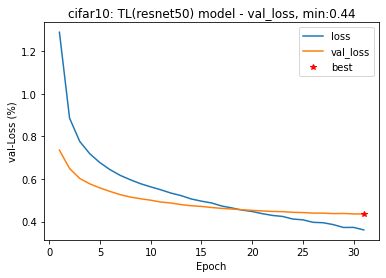

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 loss 시각화.
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10: TL(resnet50) model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],2)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

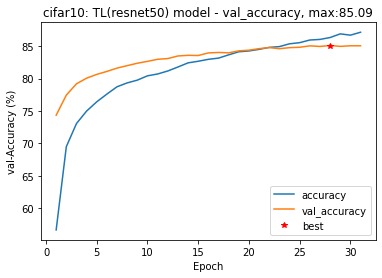

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 accuracy 시각화.
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10: TL(resnet50) model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],2)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

Let's save the model as an h5 file and load it bach so we don't need to retrain everytime

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 65s 204ms/step - loss: 0.4355 - accuracy: 0.8505


[0.4354960322380066, 0.8504999876022339]

In [ ]:
model.save('cifar10_SGD_ep20acc88.hdf5')
# Load the saved model
model = tf.keras.models.load_model('cifar10_SGD_ep20acc88.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Next, let's evaluate our model on the test set. This yields a 98.79% accuracy

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 65s 203ms/step - loss: 0.4355 - accuracy: 0.8505


[0.4354960322380066, 0.8504999876022339]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                        

#### Visualization #1

The training/validation loss and accuracy visualizations are shown below

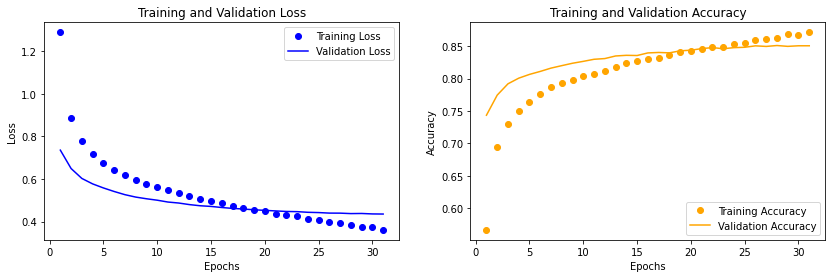

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### Visualizing Intermediate Activations

#### Visualization #2

Let's take a look at how our images look before going into visualization techniques 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

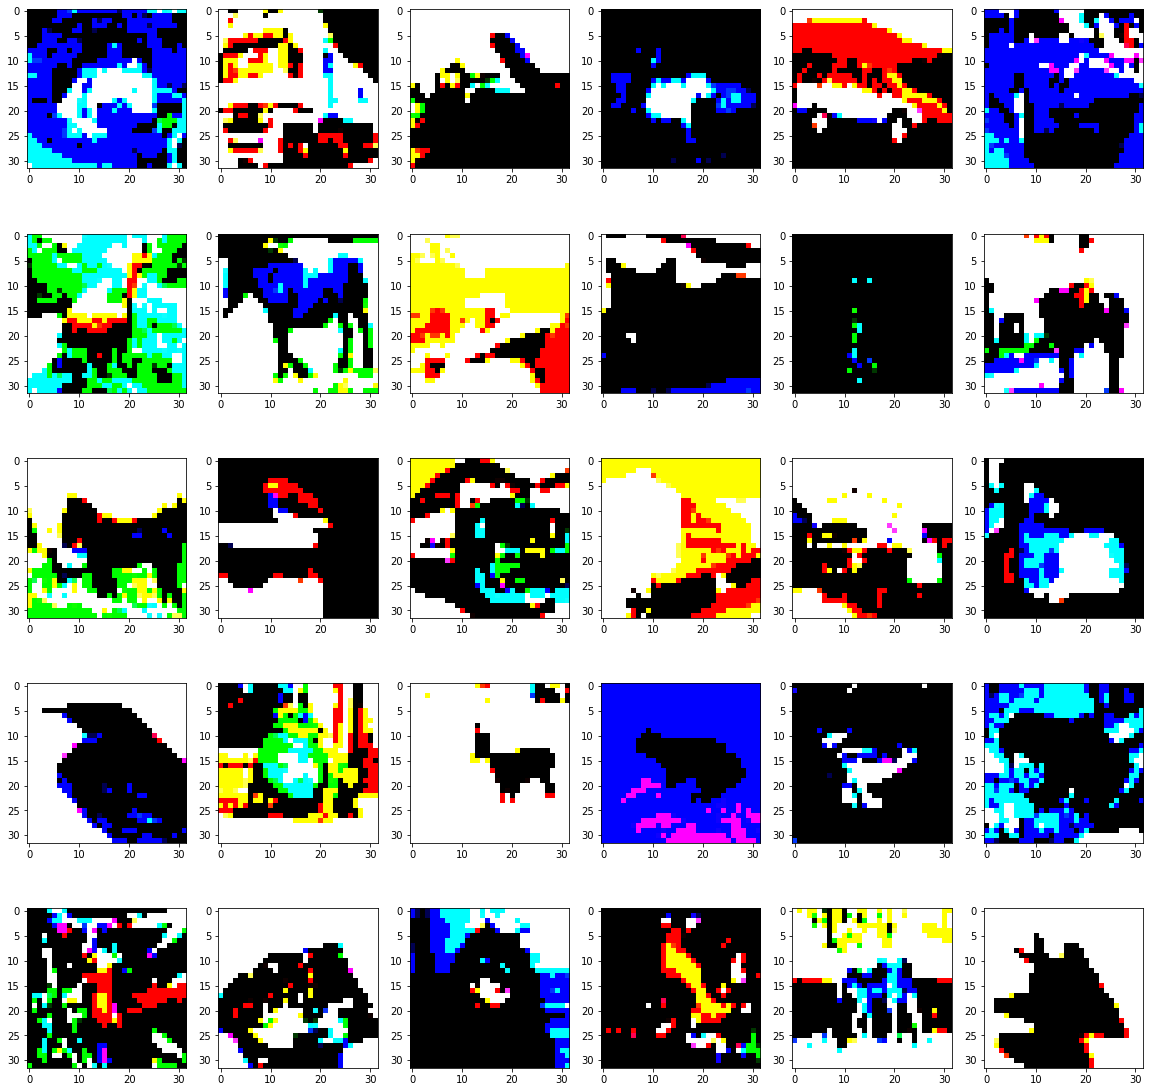

In [ ]:
plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(x_train[i])

Next, let's grab the activations for the layers in ResNet

In [ ]:
layer_outputs = [layer.output for layer in TL_base.layers[2:8]]

activation_model = models.Model(inputs=TL_base.input, outputs=layer_outputs)

Now let's choose an image to visualize with the activations from ResNet

In [ ]:
img = x_train[29]
# img = Image.fromarray(img, 'RGB')
# img.save('outfile.jpg')
# cv2.imwrite('myImage.png',img)

# img = image.load_img('outfile.jpg', target_size=(200, 200))
# img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]

#### Visualization #3

The first image shows the excited activations of the neural network when an image of an airplane is passed through

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

The original image is shown below

In [ ]:
plt.figure()
plt.imshow(x_train[29])